In [1]:
import scanpy as sc

import gc

In [2]:
import pandas as pd
import csv
import networkx as nx

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.sparse import csr_matrix

In [4]:
import torch.nn as nn
import torch 
import torch.nn.functional as F

# Model Definition for scEGA


My column vector is my vector of cell features, each column would contain the features of the cell matrix.

In [5]:
class graphattention_layer(nn.Module):
    def __init__(self,input_size,output_size,adjM):
        #WkH_{i-1} is of dimension : CurrentNodeShape x N  
        self.inpshape = input_size
        self.opshape = output_size
        self.A = adjM
        super(graphattention_layer,self).__init__()
        self.vkt = nn.Linear(in_features=output_size,out_features=  1)
        self.vkr = nn.Linear(in_features=output_size,out_features= 1)
        self.W =  nn.Linear(in_features=input_size,out_features=output_size) 
    def forward(self, H_k):
        #H_k represents the previous layer's graph representation
        M_s = self.A * self.vkt(F.relu(self.W(H_k))).T
        M_r = (self.A * self.vkr(F.relu(self.W(H_k))).T).T
        Attention = F.softmax(F.sigmoid(M_s+M_r))
        H_new = Attention@F.relu(self.W(H_k))
        return H_new

In [6]:
class encoder(nn.Module):
    def __init__(self,adjM):
        super(encoder,self).__init__( )
        #remember that in pytorch, your input_size is the last dimension of your input
        # So when my input is F*N, input_size = F
        # also a row in my matrix corresponds to a cell's representation
        self.layer1 = graphattention_layer(input_size=adjM.shape[0]
                                           ,output_size=512
                                           ,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=512
                                           ,output_size=256
                                           ,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=256
                                           ,output_size=64
                                           ,adjM=adjM)
    def forward(self, X):
        # X here is the adjacency matrix representing the cell graph
        # I'm gonna tranpose it once in the start, and then at the end.
        H1 = self.layer1(X.T)
        H2 = self.layer2(H1)
        H3 = self.layer3(H2)
        # H3 is of size N*64
        # I'm gonna transpose it back to 64*N
        return H3.T  

In [7]:
class decoder(nn.Module):
    def __init__(self,adjM,gene_embeddings):
        super(encoder,self).__init__()
        self.gGraph = gene_embeddings
        self.layer1 = graphattention_layer(input_size=64,
                                           output_size=256,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=256,
                                           output_size=512,adjM=adjM)
        self.layer1 = graphattention_layer(input_size=512,
                                           output_size=adjM.shape[0],adjM=adjM)
    def forward(self, H):
        #H here is the encoder's output
        #I'm gonna stack the gene embeddings to the H matrix
        #Encoder should have returned a 64*N matrix
        #Gene embeddings should be of dimension 64* num_nodes , which was 647 for the first run.
        # So we're concatenating a 64*647 matrix to a 64*N
        decoderPass = torch.cat((self.gGraph, H), dim=1)
        decoderPass = decoderPass.T
        # Now its a (N+graph_nodes)*64 matrix
        H1 = self.layer1(decoderPass)
        H2 = self.layer2(H1)
        H3 = self.layer3(H2)
        return H3

In [8]:
class scdEGA(nn.Module):
    def __init__(self,hidden_size,GeneCellMatrix,adjM,GeneGraph):
        super.__init__(scdEGA)
        self.gc = GeneCellMatrix
        self.encoder = encoder(hidden_size,adjM)
        self.decoder = decoder(hidden_size,adjM,GeneGraph)
    def forward(self, H):
        H1 = self.encoder(H)
        H2 = self.decoder(H1)
        reconstruction_loss = F.mse_loss(H2,self.gc)
        return H2

In [9]:
check = graphattention_layer(input_size=50,output_size=500,adjM=torch.rand(size=(50,50)))
import torch.nn.functional as F
mat = torch.rand(size=(50,50)) # 50 nodes , each of a feature size of 100
print(check(mat).shape)
check2 = graphattention_layer(input_size=500,output_size=256,adjM=torch.rand(size=(50,50)))
print(check2(check(mat)).shape)

torch.Size([50, 500])
torch.Size([50, 256])


C:\Users\saira\AppData\Local\Temp\ipykernel_27784\440043417.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Attention = F.softmax(F.sigmoid(M_s+M_r))


In [10]:
import torch.nn.functional as F
a =torch.rand(size=(100,50))
print(F.relu(a))

tensor([[0.9830, 0.0666, 0.9634,  ..., 0.6786, 0.4943, 0.1095],
        [0.3541, 0.2721, 0.0681,  ..., 0.4730, 0.1818, 0.2890],
        [0.8241, 0.5133, 0.9716,  ..., 0.0615, 0.6529, 0.4239],
        ...,
        [0.1774, 0.8390, 0.0128,  ..., 0.4088, 0.1954, 0.3321],
        [0.7808, 0.2350, 0.6650,  ..., 0.5579, 0.4281, 0.1178],
        [0.0132, 0.7050, 0.4484,  ..., 0.3972, 0.2742, 0.7856]])


In [11]:
def csnedge(gx, gy, boxsize=0.1):
    """
    The normalized statistic of edge x-y.
    
    Parameters:
    gx, gy: Gene expression values of gene x and gene y. If there are n cells, gx and gy are 1D arrays of length n.
    boxsize: Size of neighborhood, Default = 0.1
    
    Returns:
    edge: 1D array of length n, the normalized statistic of edge x-y in all cells.
    """
    
    n = len(gx)
    upper = np.zeros(n)
    lower = np.zeros(n)
    a = np.zeros((2, n))
    B = [None, None]
    
    for i in range(2):
        g = gx if i == 0 else gy
        s1 = np.sort(g)
        s2 = np.argsort(g)
        n0 = n - np.sum(np.sign(s1))
        h = round(boxsize / 2 * np.sum(np.sign(s1)))
        k = 1
        
        while k <= n:
            s = 0
            while k + s + 1 <= n and s1[k + s] == s1[k - 1]:
                s += 1
            if s >= h:
                upper[s2[k - 1:k + s]] = g[s2[k - 1]]
                lower[s2[k - 1:k + s]] = g[s2[k - 1]]
            else:
                upper[s2[k - 1:k + s]] = g[s2[min(n - 1, k + s + h - 1)]]
                lower[s2[k - 1:k + s]] = g[s2[max(n0 * (n0 > h), k - h) - 1]]
            k = k + s + 1
        
        B[i] = (g[:, None] <= upper) & (g[:, None] >= lower)
        a[i, :] = np.sum(B[i], axis=0)
    
    edge = (np.sum(B[0] & B[1], axis=0) * n - a[0, :] * a[1, :]) / np.sqrt(a[0, :] * a[1, :] * (n - a[0, :]) * (n - a[1, :]) / (n - 1))
    
    return edge

In [12]:


def csnet(data, c=None, alpha=0.01, boxsize=0.1, weighted=0):
    """
    Construction of cell-specific networks.
    
    Parameters:
    data: Gene expression matrix, rows = genes, columns = cells.
    c: Construct the CSNs for all cells if None; Construct the CSN for cell k if c is k.
    alpha: Significant level (e.g., 0.001, 0.01, 0.05 ...); larger alpha leads to more edges, Default = 0.01.
    boxsize: Size of neighborhood, Default = 0.1.
    weighted: 1 if edge is weighted, 0 if edge is not weighted (Default).
    
    Returns:
    csn: Cell-specific network, the kth CSN is in csn[k]; rows = genes, columns = genes.
    """
    
    n1, n2 = data.shape
    if c is None:
        c = range(n2)
    
    # Define the neighborhood of each plot
    upper = np.zeros((n1, n2))
    lower = np.zeros((n1, n2))
    for i in range(n1):
        s1 = np.sort(data[i, :])
        s2 = np.argsort(data[i, :])
        n3 = n2 - np.sum(np.sign(s1))
        h = round(boxsize / 2 * np.sum(np.sign(s1)))
        k = 1
        while k <= n2:
            s = 0
            while k + s + 1 <= n2 and s1[k + s] == s1[k - 1]:
                s += 1
            if s >= h:
                upper[i, s2[k - 1:k + s]] = data[i, s2[k - 1]]
                lower[i, s2[k - 1:k + s]] = data[i, s2[k - 1]]
            else:
                upper[i, s2[k - 1:k + s]] = data[i, s2[min(n2 - 1, k + s + h - 1)]]
                lower[i, s2[k - 1:k + s]] = data[i, s2[max(n3 * (n3 > h), k - h) - 1]]
            k = k + s + 1
    
    # Construction of cell-specific network
    csn = [None] * n2
    B = np.zeros((n1, n2))
    p = -norm.ppf(alpha)
    for k in c:
        for j in range(n2):
            B[:, j] = (data[:, j] <= upper[:, k]) & (data[:, j] >= lower[:, k])
        a = np.sum(B, axis=1)
        d = (B @ B.T * n2 - np.outer(a, a)) / np.sqrt(np.outer(a, a) * np.outer(n2 - a, n2 - a) / (n2 - 1) + np.finfo(float).eps)
        np.fill_diagonal(d, 0)
        if weighted:
            csn[k] = d * (d > 0)
        else:
            csn[k] = csr_matrix(d > p)
        print(f'Cell {k} is completed')
    
    return csn

In [31]:
adata.X.T[1].shape

(56,)

In [32]:
cell_specific_graph_set = csnet(adata.X.T, c=None, alpha=0.01, boxsize=0.1, weighted=0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Part 1:Data preprocessing

This will involve the following steps:
1. Obtaining a knn cell-cell graph
2. Obtaining a gene-gene graph based on protein-protein interactomes from https://string-db.org/cgi/network?taskId=bSmGYnEnGRS8&sessionId=bG2dm5uLdSGY

### Step 1 : Obtaining Cell matrix

In [13]:
adata = sc.read_text("./GSE57249_fpkm.txt")
adata = adata.T
sc.pp.pca(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 56 × 25737
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [15]:
adata[1].shape

(1, 25737)

In [ ]:
adata[1]

In [10]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 56 × 25737
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

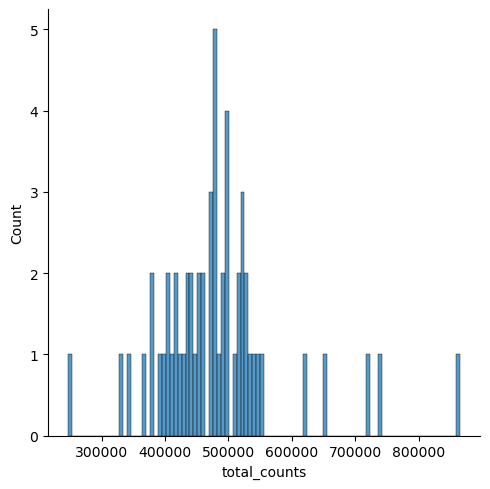

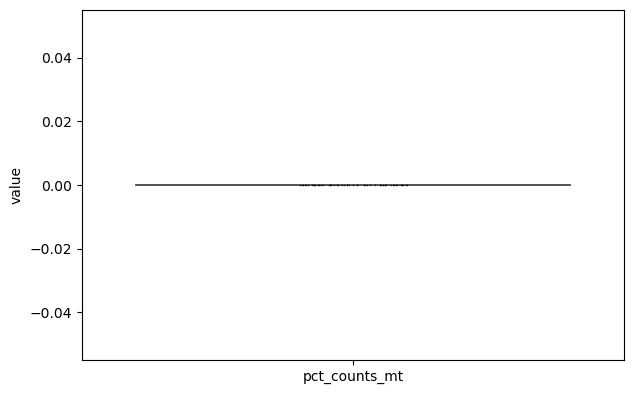

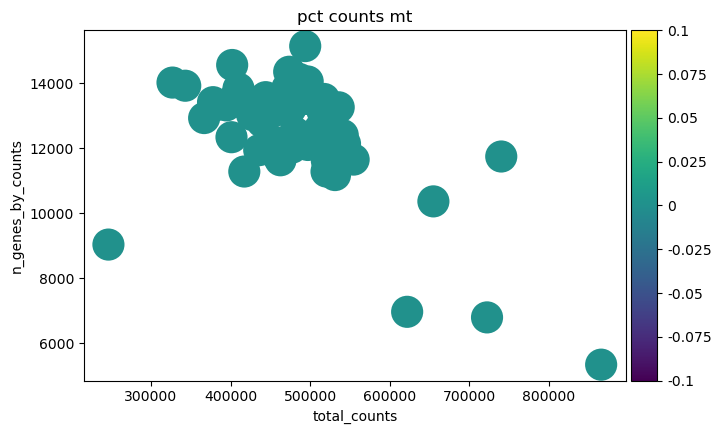

In [11]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Theres like no mtrna lol.

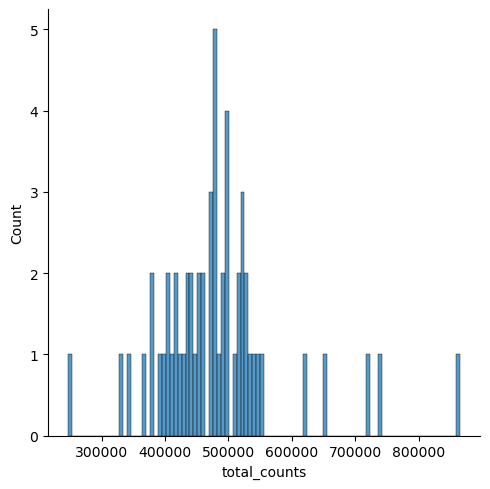

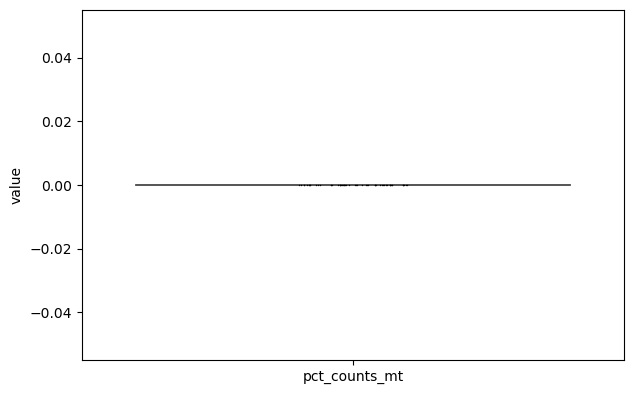

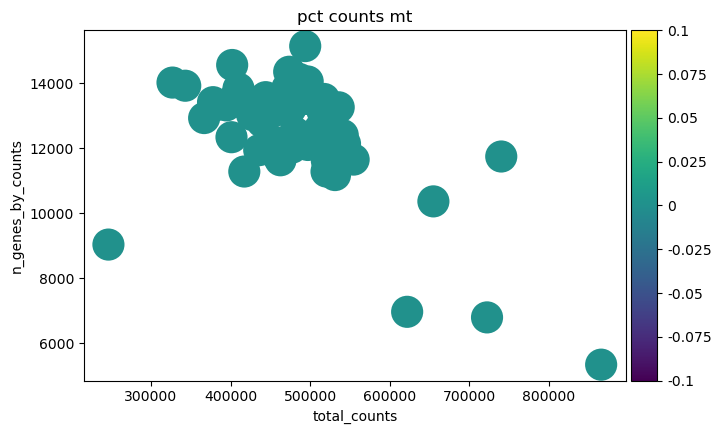

In [12]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [13]:

# Remove cells with a minimum number of expressed genes
sc.pp.filter_cells(adata, min_genes=3)

# Print the updated shape of the AnnData object
print("Updated shape:", adata.shape)

Updated shape: (56, 25737)


In [14]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
adj_list = adata.obsp["distances"].indices.reshape(adata.shape[0],-1)

c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)


c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [16]:
sc.neighbors.neighbors(adata.T,5)

c:\Users\saira\anaconda3\envs\Pytorch\Lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 56 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


Our adjacency matrix in this case is simply our knn matrix, where we store the indices("is:cells"), whose expressions are closest to the cell of that row.

In [17]:
A = torch.zeros(size=(adata.T.shape[1],adata.T.shape[1]))
for i in range(adj_list.shape[0]):
    for j in range(5):
        A[i][adj_list[i][j]] = 1

Now to obtain the gene-gene graph



In [18]:
with open("highly_variable_genes.txt", "w") as f:    
     f.write(','.join(adata.var_names[adata.var["highly_variable"]]))

In [19]:
edge_list = pd.DataFrame(csv.reader(open("string_interactions.tsv"),delimiter="\t"))
edge_list.columns = edge_list.iloc[0]
edge_list = edge_list.drop(0)

In [32]:
edge_list

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
1,0610010F05Rik,Ahsa2,10090.ENSMUSP00000044265,10090.ENSMUSP00000020529,0,0,0,0,0.091,0,0,0.392,0.423
2,1300017J02Rik,Trf,10090.ENSMUSP00000035163,10090.ENSMUSP00000035158,0,0,0.061,0.959,0.104,0,0.900,0,0.908
3,1300017J02Rik,Ica1,10090.ENSMUSP00000035163,10090.ENSMUSP00000040062,0,0,0,0,0,0,0,0.473,0.473
4,1600014C10Rik,Coasy,10090.ENSMUSP00000130271,10090.ENSMUSP00000102929,0,0,0,0,0.050,0,0,0.538,0.542
5,1600014C10Rik,BC048679,10090.ENSMUSP00000130271,10090.ENSMUSP00000120616,0,0,0,0,0,0,0,0.604,0.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458,Zfp933,Rpp25,10090.ENSMUSP00000101343,10090.ENSMUSP00000079358,0,0,0,0,0,0.073,0,0.388,0.408
3459,Zglp1,Figla,10090.ENSMUSP00000111157,10090.ENSMUSP00000032070,0,0,0,0,0.089,0,0,0.402,0.432
3460,Znrd1as,Rpp21,10090.ENSMUSP00000048695,10090.ENSMUSP00000025319,0,0,0,0,0.079,0,0,0.538,0.556
3461,Zswim2,Cct6b,10090.ENSMUSP00000044913,10090.ENSMUSP00000021040,0,0,0,0,0.052,0,0,0.511,0.517


In [20]:
gene_graph = nx.Graph()
gene_graph.add_edges_from(edge_list[["node1_string_id","node2_string_id"]].values)

In [31]:
gene_graph.nodes

NodeView(('10090.ENSMUSP00000044265', '10090.ENSMUSP00000020529', '10090.ENSMUSP00000035163', '10090.ENSMUSP00000035158', '10090.ENSMUSP00000040062', '10090.ENSMUSP00000130271', '10090.ENSMUSP00000102929', '10090.ENSMUSP00000120616', '10090.ENSMUSP00000083557', '10090.ENSMUSP00000027959', '10090.ENSMUSP00000074190', '10090.ENSMUSP00000023851', '10090.ENSMUSP00000030103', '10090.ENSMUSP00000037417', '10090.ENSMUSP00000126763', '10090.ENSMUSP00000118931', '10090.ENSMUSP00000075953', '10090.ENSMUSP00000059095', '10090.ENSMUSP00000114041', '10090.ENSMUSP00000013227', '10090.ENSMUSP00000002844', '10090.ENSMUSP00000006478', '10090.ENSMUSP00000078697', '10090.ENSMUSP00000109523', '10090.ENSMUSP00000055327', '10090.ENSMUSP00000025218', '10090.ENSMUSP00000113715', '10090.ENSMUSP00000031536', '10090.ENSMUSP00000082232', '10090.ENSMUSP00000074557', '10090.ENSMUSP00000092099', '10090.ENSMUSP00000044222', '10090.ENSMUSP00000056691', '10090.ENSMUSP00000101383', '10090.ENSMUSP00000028369', '10090.ENS

In [21]:
import node2vec

In [22]:
from node2vec import Node2Vec


node2vec = Node2Vec(gene_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = model.wv.vectors

Computing transition probabilities: 100%|██████████| 647/647 [00:00<00:00, 4511.04it/s]


In [23]:

# for i in range(edge_list.shape[0]):
#     gene_graph.add_edge(edge_list., edge_list.iloc[i,1])

In [24]:
node_embeddings.shape

(647, 64)